In [18]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [49]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-05-27 00:00:00-04:00,3015.649902,-1.000332,-1.000332,-1.000332,0.570767,-1.000328,1,0.999997,0.333333,0.999989,0.4,0.999986,0.52
2020-05-28 00:00:00-04:00,3046.610107,-1.000328,-1.000328,-1.000328,0.456700,-1.000331,-1,0.999997,1.000000,0.999988,0.6,0.999984,0.52
2020-05-29 00:00:00-04:00,3025.169922,-1.000331,-1.000331,-1.000331,0.678666,-1.000329,1,1.000000,0.333333,0.999993,0.6,0.999987,0.44
2020-06-01 00:00:00-04:00,3038.780029,-1.000329,-1.000329,-1.000329,0.365199,-1.000326,1,1.000000,0.333333,0.999994,0.6,0.999987,0.44
2020-06-02 00:00:00-04:00,3064.780029,-1.000326,-1.000326,-1.000326,0.426729,-1.000323,1,0.999998,0.333333,0.999993,0.6,0.999985,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00-04:00,5211.370117,-1.000192,-1.000192,-1.000192,0.196555,-1.000192,1,1.000000,0.333333,1.000000,0.0,0.999999,0.12
2024-04-09 00:00:00-04:00,5217.029785,-1.000192,-1.000192,-1.000192,0.211248,-1.000194,-1,0.999999,0.333333,1.000000,0.2,0.999999,0.12
2024-04-10 00:00:00-04:00,5167.879883,-1.000194,-1.000194,-1.000194,0.264655,-1.000193,1,1.000001,0.333333,1.000002,0.0,1.000001,0.12


In [50]:
from numpy.random import default_rng

#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
train_predictors = predictors[1:948,:]
test_predictors = predictors[949:np.size(predictors, axis=0),:]
rng = default_rng()
numbers = rng.choice(949, size=100, replace=False)
encoder_training_predictors = predictors[numbers]
encoder_training_labels = labels[numbers]
train_labels = labels[0:948]
test_labels = labels[949:np.size(predictors, axis=0)]
num_features = np.size(predictors, axis=1)

In [21]:
import json
import time
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [22]:
encoding_depth = 6
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=encoding_depth)

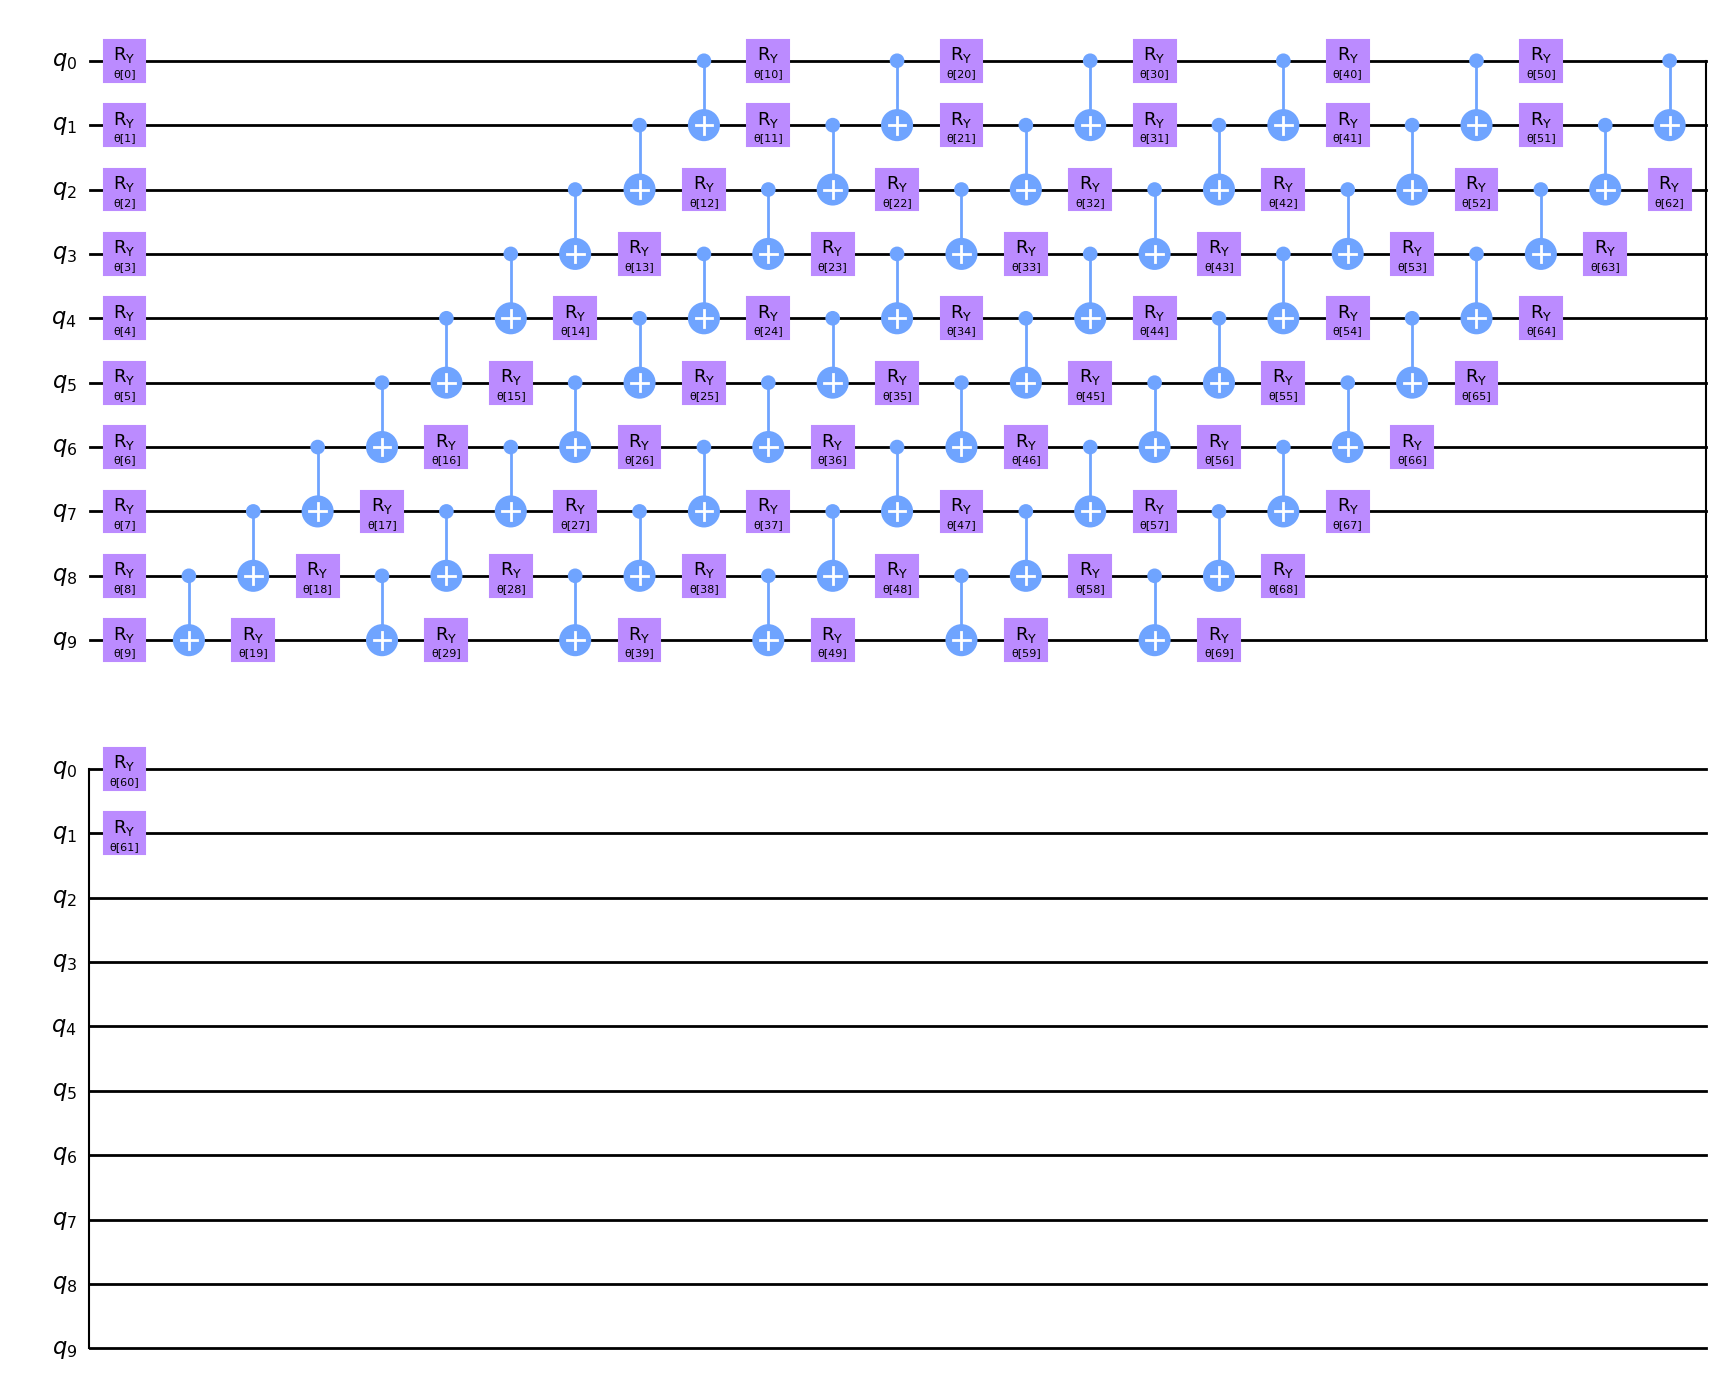

In [23]:
num_qubits = 10
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

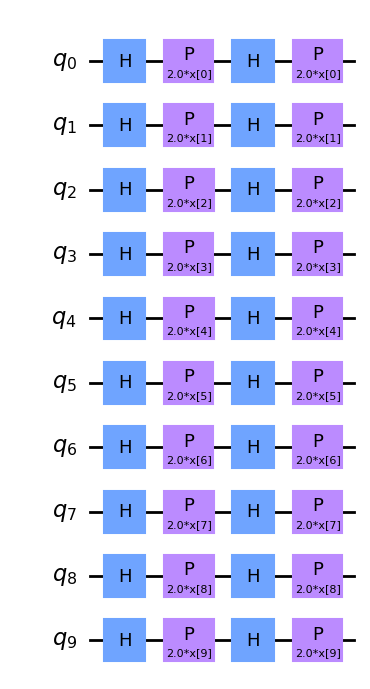

In [24]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(num_features)
feature_map.decompose().draw("mpl", style="clifford")

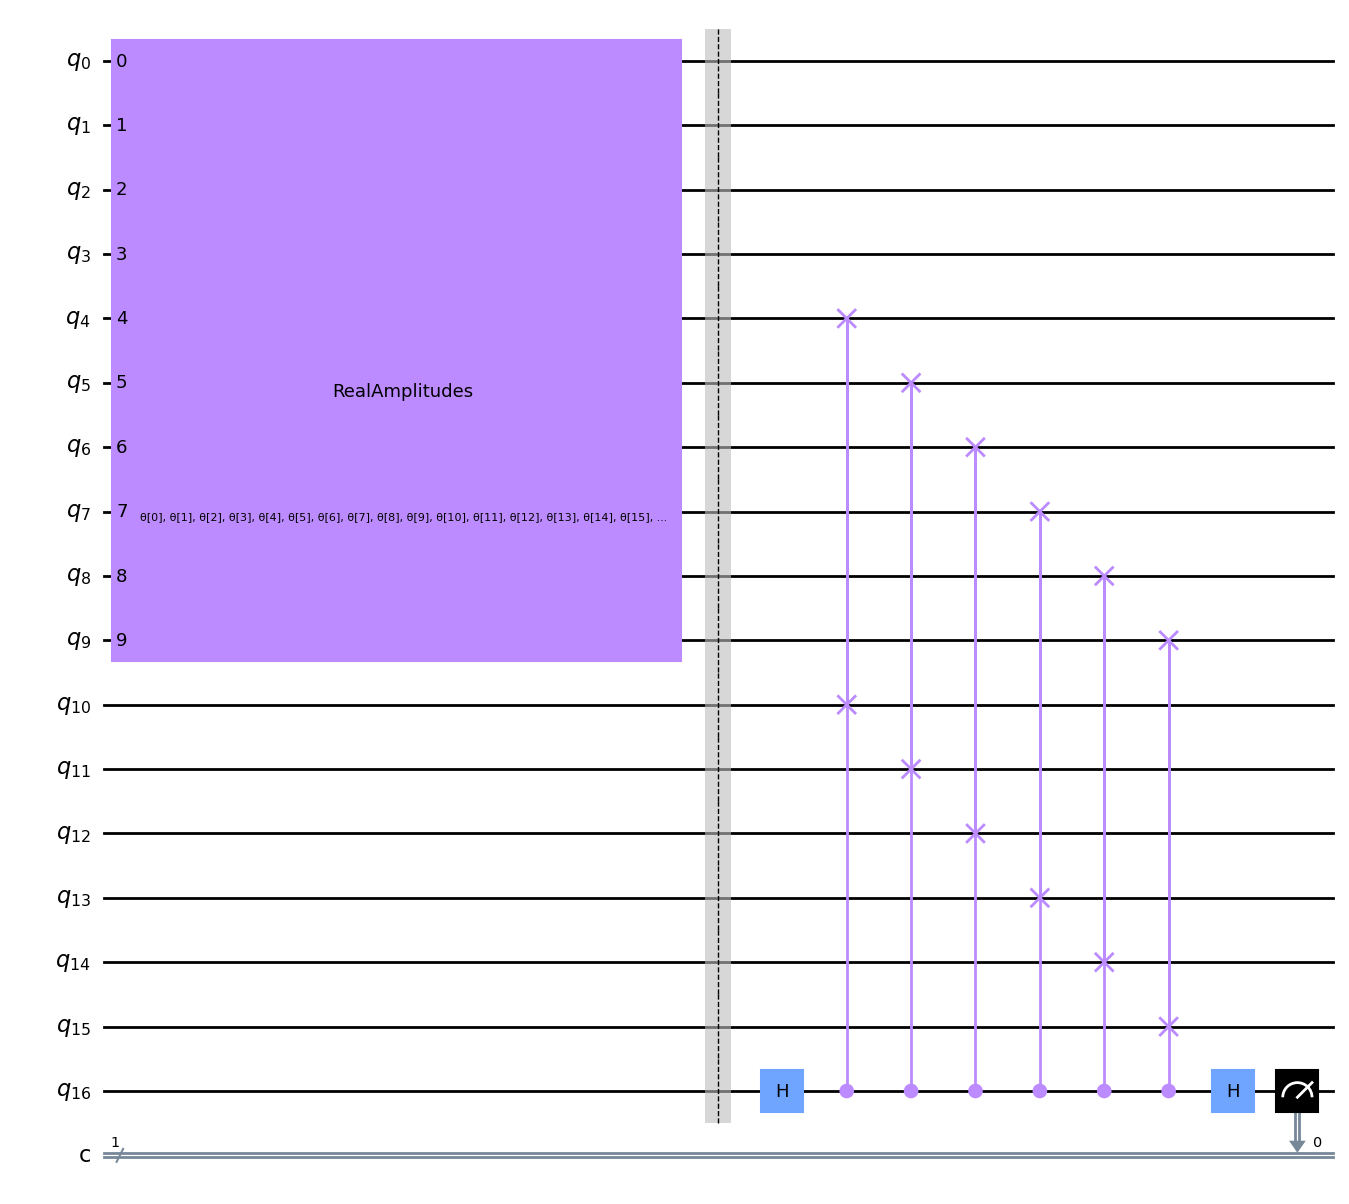

In [25]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 4
num_trash = 6
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

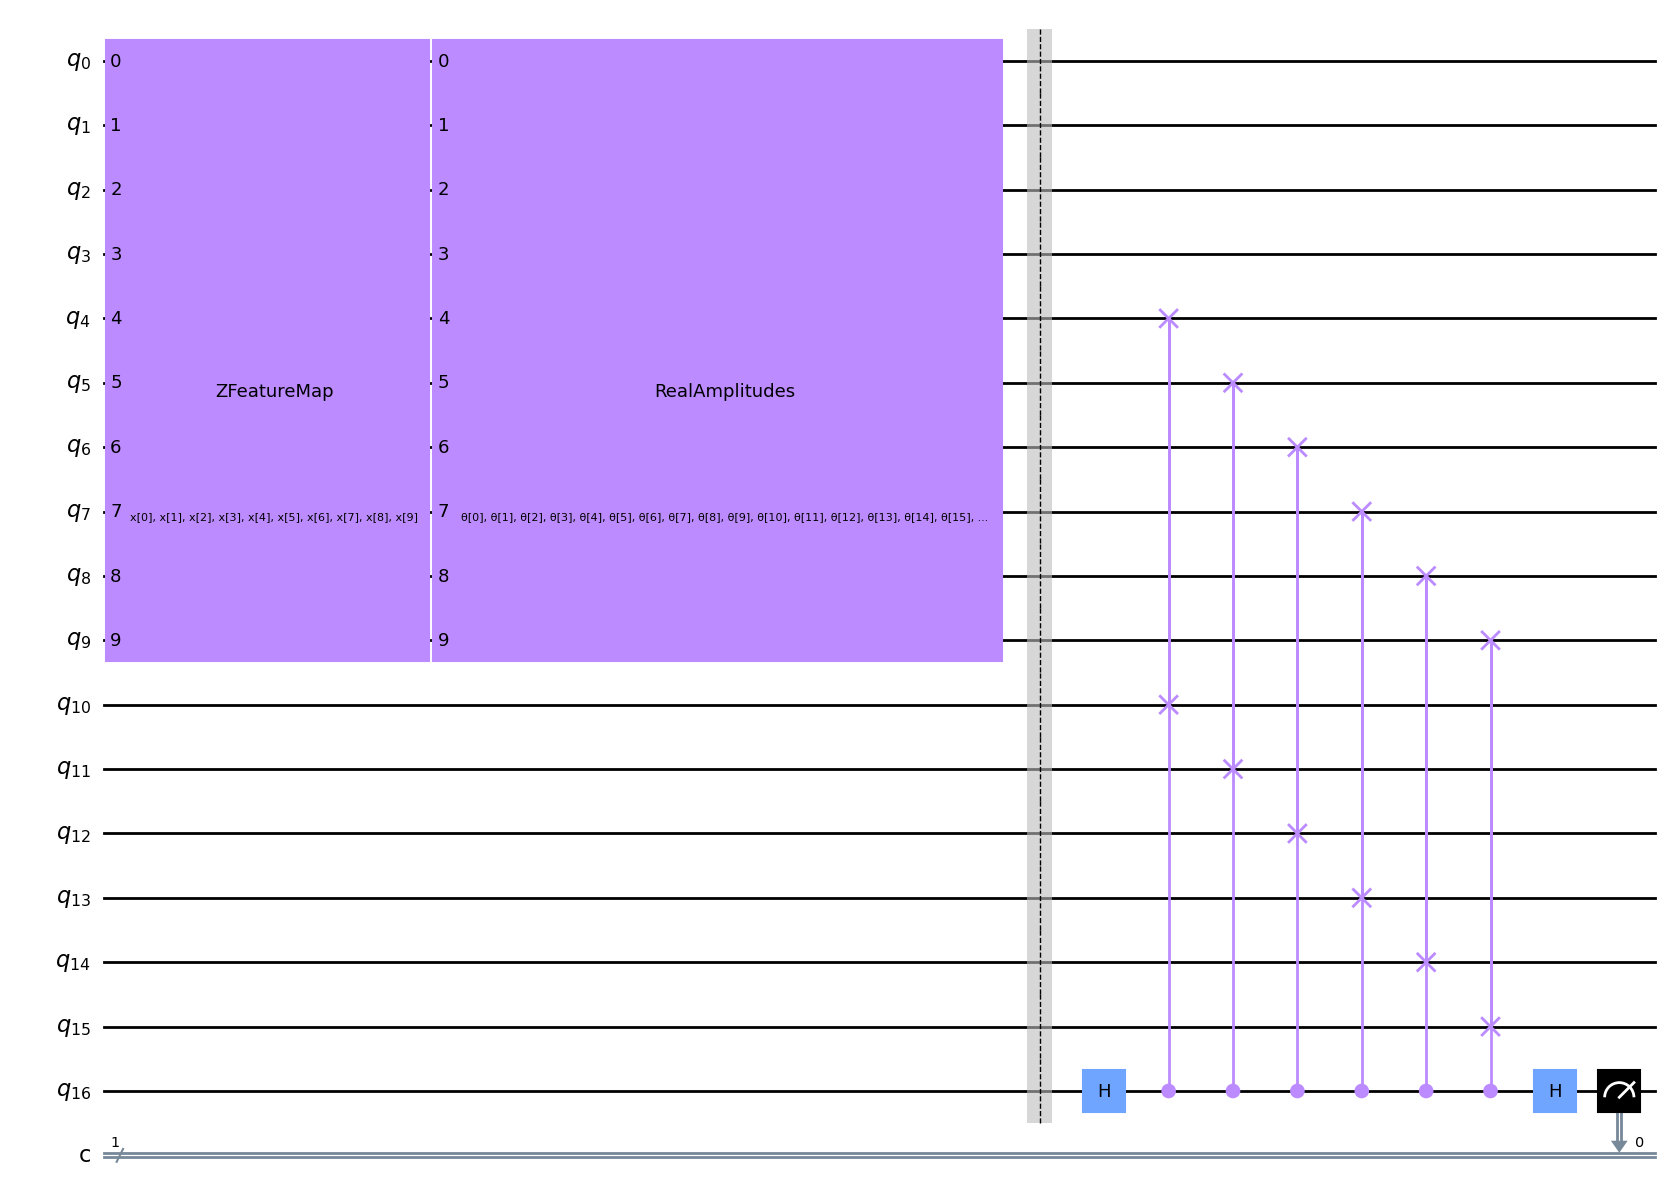

In [26]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc.compose(feature_map, inplace=True)
qc.compose(ae, inplace=True)
qc.draw(output="mpl", style="clifford")

In [27]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [28]:
def cost_func_domain(params_values):
    probabilities = qnn.forward(encoder_training_predictors, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

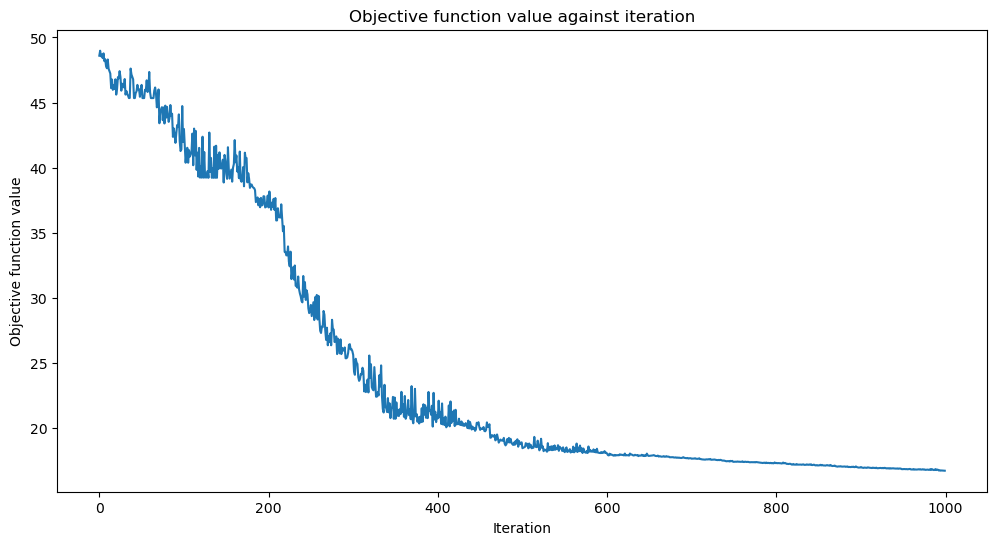

[ 9.06794670e-01  2.50567422e+00  4.10967458e-01  1.77369648e+00
  2.72855450e-01  3.29405973e+00  1.07875289e+00  1.23633239e+00
  1.12367438e+00  5.66708594e-01  1.92267145e+00  1.55054095e+00
  1.57063742e+00  1.61201021e+00  1.53447627e+00  1.56143125e+00
  1.58746757e+00  4.94426725e-01  5.07523683e-01  2.29193748e+00
  5.20968440e-01 -7.27923572e-02  9.23095136e-01 -5.34202733e-02
  4.03146661e-01  7.54185033e-01  9.93476702e-01 -1.74617351e-01
  1.18898452e+00  5.94851640e-01  3.67526852e-01  1.56825935e+00
  3.94526250e-01  8.08752914e-01  5.54872977e-01  2.53713657e-01
  4.25985202e-02  2.18190661e-02  2.14971477e-02 -2.57823807e-03
  1.14642676e+00  6.87252912e-01  5.85146185e-01  1.52077124e+00
  1.35677079e+00  1.74587072e+00 -4.05973411e-02 -2.16594590e-01
  3.14062397e-02  2.33409116e-01 -7.45275301e-01 -4.16364439e-01
  2.36643807e+00  5.78265129e-01  7.94951750e-01  5.50261484e-01
 -2.04060565e-02  1.41202894e-02 -1.55559622e-02 -1.25668343e-03
  7.46082222e-01  1.02261

In [12]:
opt = COBYLA(maxiter=1000)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

opt_result = opt.minimize(cost_func_domain, initial_point)

#trained parameters
print(opt_result.x)

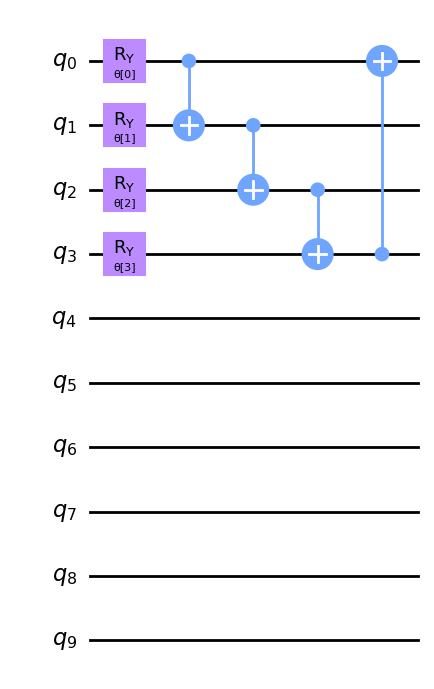

In [33]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = num_latent

def parametrized_gates(params):
    target = QuantumCircuit(num_features)
        
    for i in range(num_params):
        target.ry(params[i], i)
        
    for i in range(num_params-1):
        target.cx(i, i+1)
        
    target.cx(num_params-1,0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

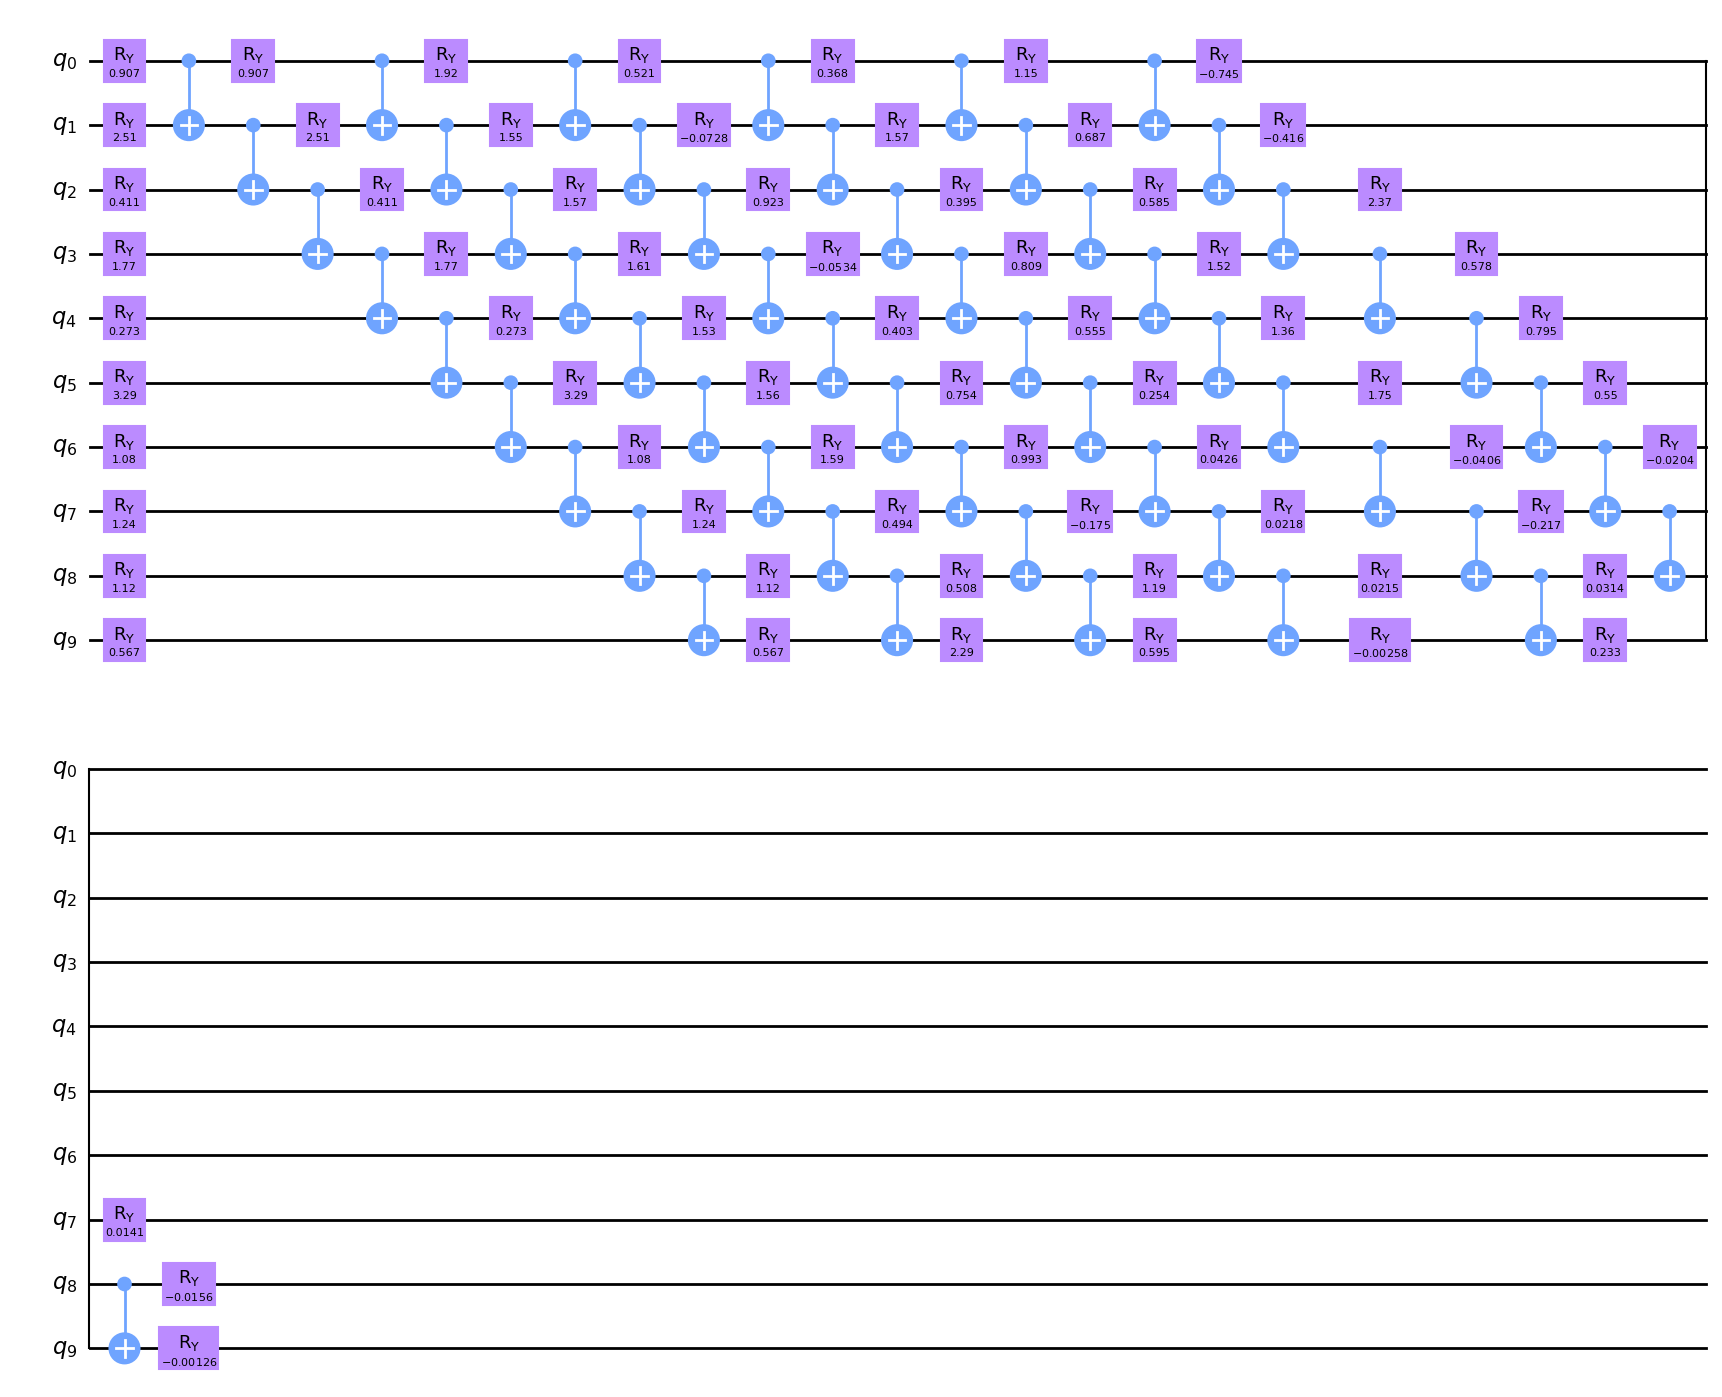

In [30]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = (encoding_depth+1)*num_features
def trained_encoder(params):
    target = QuantumCircuit(num_features)
    
    for i in range(num_features):
        target.ry(params[i], i)
        
    for i in range(encoding_depth):
        for j in range(num_features):
            if (j!=num_features-1):
                target.cx(j, j+1)
            target.ry(params[j + 10*i], j)
    
    return target

#Draws the ciruit for parametrized gate
circuit = trained_encoder(opt_result.x)
circuit.draw("mpl", style="clifford")

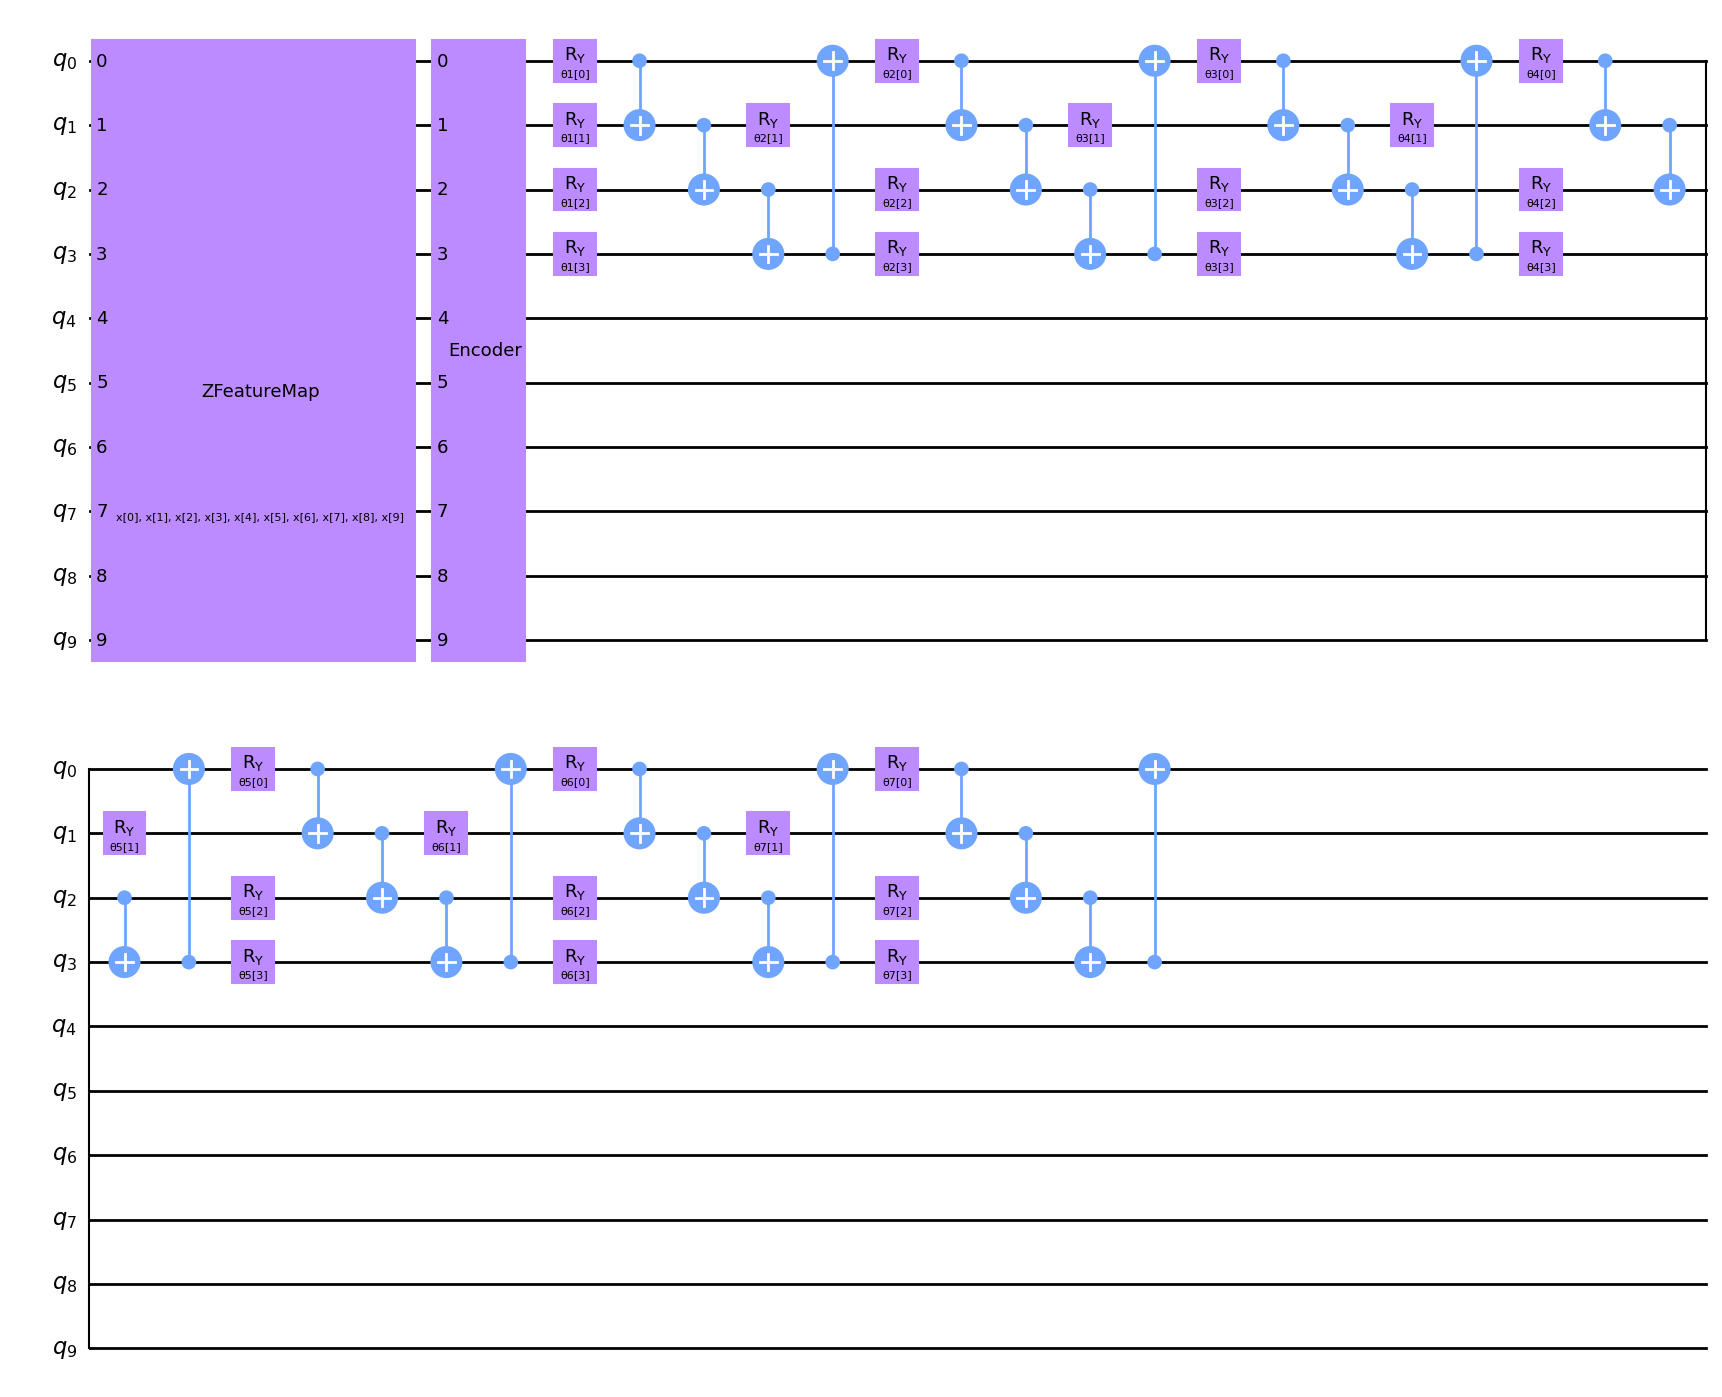

In [34]:
#Sets up full circuit with inputs and network
#network.clear()
#ml_circuit.clear()
circuit_depth = 7
network = parametrized_gates(ParameterVector("θ1", length=num_params))
for i in range(circuit_depth-1):
    network.compose(parametrized_gates(ParameterVector(f"θ{i+2}", length=num_params)), inplace=True)

ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(feature_map, inplace=True)
e = trained_encoder(opt_result.x)
e = e.to_instruction(label="Encoder")
ml_circuit.append(e, range(num_features))
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [35]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [36]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("I" * 9 + "Z", 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [53]:
#Function used in classifier to plot objective function at each iteration
max_iters = 400
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [54]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

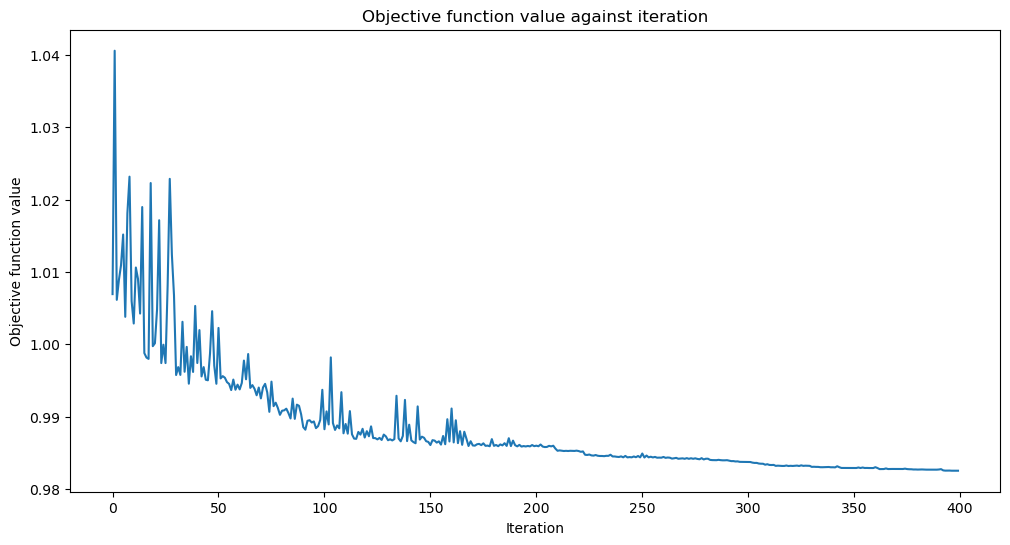

Accuracy from the test data : 53.22%


In [55]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(encoder_training_predictors, encoder_training_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")

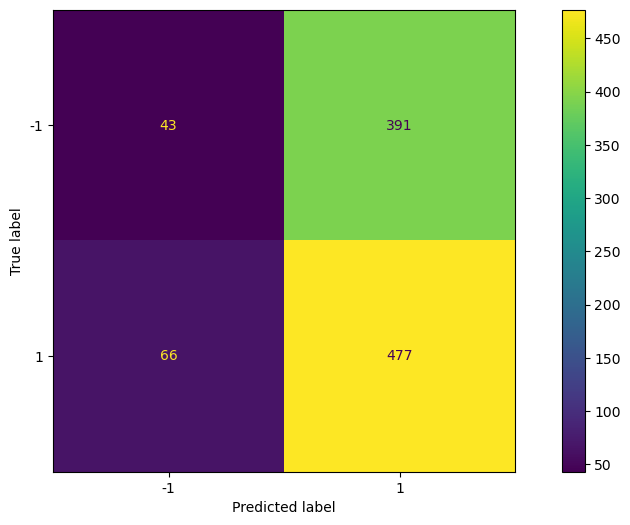

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, classifier.predict(predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()